# Notes: 
- interpretability is understanding the inner workings of the model, WHY does it work
- explainability is just explaining the decisions made
- XAI, explainable AI, is what we can use to interpret / explain the models that are complex, typically by giving a numerical value to each model input to determine how important it was for the model to make its prediction
- these DONT tell you about the data generating mechanism (real world)
##
- permutation feature importance is model agnostic
- permute means randomly sort, jumble up
- we permute each of the individual features/ inputs one by one i think and redo the math in the model and it gives you purposefully incorrect predictions, you compare the error in that to the error in your original prediction and the difference in error shows you how important that thing was for the predictive model 

# Hwk Questions

Permutation Feature Importance

What are the most important variables for the prediction tasks we’ve done in class
thus far?

Revisit the following two learning tasks, and plot the variable feature importances as a
barchart using the optimal models you used in the prior homeworks: EPA AQS Data linear classification, NOAA Buoy Predictions for XGBoost, decision trees, and a linear method.

Are they the same or different for different models?

- No - dominant wave period was significantly more important for the boosted model, while average wave period was significantly important for the tree regressor. The random forest had dominant wave period as most significant, but not by as big of a margin, and the same with the linear regression model with average wave period. 

#####

Methods Description

Read Flora et al. (2024) A Machine Learning Explainability Tutorial for Atmospheric
Sciences (https://doi.org/10.1175/AIES-D-23-0018.1):
https://journals.ametsoc.org/view/journals/aies/3/1/AIES-D-23-0018.1.xml

How do they describe the permutation feature importance method we learned
in class?
- They say its the most common way to measure feature importance for a specific model, and that it evaluates the changes in the model’s performance (error) after using purposefully incorrect / jumbled up values to run the model and comparing the error to that for correct predictions. They note that there are important considerations, like that permuting the values in features messes with the relationship that might exist between different features and how they affect the prediction together (or I believe Thats what they’re saying).

Describe an additional method for explainability from this paper. How does it
work? Is it model agnostic or model specific?
- Another method is with a tree interpreter, which is a type of local explainability, which asks why a model made a specific prediction for a certain set of examples, rather than why / how the model makes predictions as a whole for all examples. It is a feature attribution method, or that it attempts to see how important an individual feature is. From what I can understand, it does so with single feature ordering, or by looking only at one particular path of branches at a time. The downside to this is that it sometimes gives less importance to nodes / features near the top of the tree because it’s focusing on later decisions. It is model specific. 

Find potential scikitlearn functions for 5 of the methods described in the paper.
Note: You don’t have to implement them.
- shap.TreeExplainer or shap.Explainer
- lime.lime_tabular.LimeTabularExplainer
- treeinterpreter.treeinterpreter.predict
- sklearn.inspection.partial_dependence
- and sklearn's permutation_importance

# Example code: 
X = array
y = array

bla = LinearRegression().fit(X,y)
result = permutation_importance(bla, X, y, n_repeats=10, random_state = 0)
- where n_repeats is the number of times they repeat this permutation thing and random_state is whatever random number you want it to start with 

- result.importances_mean is avg importance
- result.importances_std is the standard deviation/ variability for the avg importance 

In [1]:
# idk what all ill need so start w just this

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.inspection import permutation_importance

from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from xgboost import XGBRegressor

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Buoy data prep

In [2]:
buoy = pd.read_csv('/Users/katherinemottola/Desktop/important/school/GEOL599/3_06_24/buoy.txt', delim_whitespace = True)

epa = pd.read_csv('/Users/katherinemottola/Desktop/important/school/GEOL599/1_24_24/LA_AQS_2023.csv')


In [3]:
cols = ['WVHT','DPD','APD','MWD','WTMP']

buoy = buoy[cols]

buoy.columns = ['Wave Height','Dominant Wave Period','Average Wave Period','Dom Direction','SST']

In [4]:
X_b = buoy[['Dominant Wave Period','Average Wave Period','Dom Direction', 'SST']].copy()
X_b = X_b.to_numpy()
X_b

array([[ 12.5 ,   7.69, 269.  ,  15.3 ],
       [ 11.76,   7.34, 272.  ,  15.3 ],
       [ 12.5 ,   7.08, 268.  ,  15.3 ],
       ...,
       [ 13.33,  10.5 , 268.  ,  16.8 ],
       [ 14.29,  10.32, 271.  ,  16.8 ],
       [ 12.5 ,  10.54, 271.  ,  16.9 ]])

In [5]:
y_b = buoy['Wave Height']
y_b = y_b.to_numpy()
y_b

array([1.12, 1.16, 1.2 , ..., 1.79, 1.66, 1.7 ])

# Buoy splits 

I'm assuming since we're not looking at errors for the different sets that I don't technically need to make splits and can just train on the actual whole data set but i made the splits just in case

In [6]:
# training and remaining instead of train and test, remaining will be what i then pull the next stuff from
X_btrain, X_bremaining, y_btrain, y_bremaining = train_test_split(X_b, y_b, test_size=0.25)

# now i can split the remaining data into the testing and validation sets
X_btest, X_bval, y_btest, y_bval = train_test_split(X_bremaining, y_bremaining, test_size=0.4)


# X_temp_train is training data, X_test as testing data, X_val is validation data
# y_temp_train is training data, y_test as testing data, y_val is validation data


# EPA data prep

In [7]:
## want to make a df with ozone, no2, and pm2.5

# ozone

dfo3 = epa[(epa['Parameter Name']=='Ozone') & (epa['Duration Description']=='1 HOUR')]

# make a variable of only the mean 
mean_o3 = dfo3["Arithmetic Mean"]

# now make a dataframe where its ONLY the columns of date and ozone 

dfo3 = pd.DataFrame(data = {"O3" : mean_o3, 'date' : dfo3["Date (Local)"]})

In [8]:
# no2

dfno2 = epa[(epa['Parameter Name']=='Nitrogen dioxide (NO2)') & (epa['Duration Description']=='1 HOUR')]

# make a variable of only the mean 
mean_no2 = dfno2["Arithmetic Mean"]

# only date and mean 
dfno2 = pd.DataFrame(data = {"NO2" : mean_no2, 'date' : dfno2["Date (Local)"]})

In [9]:
# pm25

dfpm = epa[(epa['Parameter Name']=='PM2.5 - Local Conditions') & (epa['Duration Description']=='1 HOUR')]

# make a variable of only the mean 
mean_pm = dfpm["Arithmetic Mean"]

# only date and mean 
dfpm = pd.DataFrame(data = {"PM2.5" : mean_pm, 'date' : dfpm["Date (Local)"]})

In [10]:
# now wanna merge the no2 to this, then pm2.5. do it in steps
# no2 first 

df_o3_no2 = dfo3.merge(dfno2, on=['date'])

df_o3_no2.head()

,O3,date,NO2
0,0.031708,2023-01-01,4.816667
1,0.031708,2023-01-01,4.550000
2,0.031708,2023-01-01,4.550000
3,0.031708,2023-01-01,4.816667
4,0.015792,2023-01-02,14.720833


In [11]:
# now pm2.5

epa_all = df_o3_no2.merge(dfpm, on=['date'])

epa_all.head()

,O3,date,NO2,PM2.5
0,0.031708,2023-01-01,4.816667,5.0875
1,0.031708,2023-01-01,4.550000,5.0875
2,0.031708,2023-01-01,4.550000,5.0875
3,0.031708,2023-01-01,4.816667,5.0875
4,0.015792,2023-01-02,14.720833,9.1875


In [12]:
# get months from 

months = pd.DatetimeIndex(epa_all['date']).month.values
months

array([1, 1, 1, ..., 9, 9, 9], dtype=int32)

In [13]:
# now make an array w the same dimensions but where all values are 0 to start with
# in the end itll just basically show whether or not its summer 

# this makes the array thing
qsummer = months - months 

# june july august months, summer = 1
qsummer[months == 6] = 1 
qsummer[months == 7] = 1
qsummer[months == 8] = 1

# march april may, spring is -1 which means we get rid of it
qsummer[months == 3] = -1 
qsummer[months == 4] = -1
qsummer[months == 5] = -1

# also get rid of fall by making it -1
qsummer[months == 9] = -1 
qsummer[months == 10] = -1
qsummer[months == 11] = -1

# this automatically makes winter = 0 bc we're leaving it as-is

In [14]:
epa_all['summer'] = qsummer

In [15]:
# get rid of all values where summer is = -1

epa_all = epa_all[epa_all['summer'] > -1]
epa_all.describe()

,O3,NO2,PM2.5,summer
count,604.000000,604.000000,604.000000,604.000000
mean,0.025534,14.908291,11.883327,0.609272
std,0.007501,6.819712,4.928007,0.488318
min,0.008333,4.250000,3.250000,0.000000
25%,0.022000,9.700000,8.545833,0.000000
50%,0.026417,13.425000,10.900000,1.000000
75%,0.031542,19.133333,15.266667,1.000000
max,0.042833,33.466667,31.979167,1.000000


In [16]:
epa_all.head()

,O3,date,NO2,PM2.5,summer
0,0.031708,2023-01-01,4.816667,5.0875,0
1,0.031708,2023-01-01,4.550000,5.0875,0
2,0.031708,2023-01-01,4.550000,5.0875,0
3,0.031708,2023-01-01,4.816667,5.0875,0
4,0.015792,2023-01-02,14.720833,9.1875,0


In [17]:
y_e = epa_all['summer']
y_e = y_e.to_numpy()
y_e

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [18]:
X_e = epa_all[['O3','NO2','PM2.5']].copy()
X_e = X_e.to_numpy()
X_e

array([[ 0.031708,  4.816667,  5.0875  ],
       [ 0.031708,  4.55    ,  5.0875  ],
       [ 0.031708,  4.55    ,  5.0875  ],
       ...,
       [ 0.025042, 18.208333, 19.341667],
       [ 0.025042, 20.458333, 19.341667],
       [ 0.025042, 20.458333, 19.341667]])

# EPA splits

In [19]:
# training and remaining instead of train and test, remaining will be what i then pull the next stuff from
X_etrain, X_eremaining, y_etrain, y_eremaining = train_test_split(X_e, y_e, test_size=0.25)

# now i can split the remaining data into the testing and validation sets
X_etest, X_eval, y_etest, y_eval = train_test_split(X_eremaining, y_eremaining, test_size=0.4)


# X_temp_train is training data, X_test as testing data, X_val is validation data
# y_temp_train is training data, y_test as testing data, y_val is validation data


# EPA data fitting

In [87]:
# epa data, ridge classifier only bc its classification

lin_e = RidgeClassifier(alpha=0.5)
lin_e.fit(X_etrain, y_etrain)

RidgeClassifier(alpha=0.5)

# Buoy data fitting

In [88]:
# buoy data

# linear model 

lin_b = linear_model.LinearRegression()
lin_b.fit(X_btrain, y_btrain)

# xgboost

boost = XGBRegressor(n_estimators=50, learning_rate=0.4)
boost = boost.fit(X_btrain, y_btrain)

# tree

tree = DecisionTreeRegressor()
tree.fit(X_btrain, y_btrain)

# forest - not sure if i need to do this as well but im gonna

forest = RandomForestRegressor(n_estimators=25)
forest.fit(X_btrain, y_btrain)

RandomForestRegressor(n_estimators=25)

# Importances of features

In [22]:
feature_names_e = [f"feature {i}" for i in range(X_e.shape[1])]
feature_names_b = [f"feature {i}" for i in range(X_b.shape[1])]

In [23]:
feature_names_e

['feature 0', 'feature 1', 'feature 2']

In [24]:
feature_names_b

['feature 0', 'feature 1', 'feature 2', 'feature 3']

In [26]:
# found this weirdly complex code online to hopefully figure out / double check that the features are just named in order
# o3, no2, pm2.5

og_names_e = ['O3', 'NO2', 'PM2.5']

# make a dictionary?? to map column indices to names
column_name_map = {i: name for i, name in enumerate(og_names_e)}

# Create feature names using the mapping
feature_names_e = [column_name_map[i] for i in range(X_e.shape[1])]

print(feature_names_e)


['O3', 'NO2', 'PM2.5']


In [25]:
# dom wave period, ba, ba, SST

og_names_b = ['Dominant Wave Period', 'Average Wave Period', 'Dom Direction', 'SST']

column_name_map = {i: name for i, name in enumerate(og_names_b)}

feature_names_b = [column_name_map[i] for i in range(X_b.shape[1])]

print(feature_names_b)

['Dominant Wave Period', 'Average Wave Period', 'Dom Direction', 'SST']


In [89]:
result_epa = permutation_importance(lin_e, X_etest, y_etest, n_repeats=10, random_state = 0)

epa_mean = result_epa.importances_mean
epa_std = result_epa.importances_std

In [90]:
# lin results

result_lin_b = permutation_importance(lin_b, X_btest, y_btest, n_repeats=10, random_state = 0)

buoy_lin_mean = result_lin_b.importances_mean
buoy_lin_std = result_lin_b.importances_std

#xgboost result

result_boost = permutation_importance(boost, X_btest, y_btest, n_repeats=10, random_state = 0)

buoy_boost_mean = result_boost.importances_mean
buoy_boost_std = result_boost.importances_std

# tree result

result_tree = permutation_importance(tree, X_btest, y_btest, n_repeats=10, random_state = 0)

buoy_tree_mean = result_tree.importances_mean
buoy_tree_std = result_tree.importances_std

# forest result

result_forest = permutation_importance(forest, X_btest, y_btest, n_repeats=10, random_state = 0)

buoy_forest_mean = result_forest.importances_mean
buoy_forest_std = result_forest.importances_std

In [91]:
for i in range(len(epa_mean)):
    print(f"EPA data: Feature '{feature_names_e[i]}' has importance {epa_mean[i]:.4f} ± {epa_std[i]:.4f}")


EPA data: Feature 'O3' has importance 0.0000 ± 0.0000
EPA data: Feature 'NO2' has importance 0.2133 ± 0.0523
EPA data: Feature 'PM2.5' has importance 0.1422 ± 0.0441


In [92]:
for i in range(len(buoy_lin_mean)):
    print(f"Buoy data, linear model: Feature '{feature_names_b[i]}' has importance {buoy_lin_mean[i]:.4f} ± {buoy_lin_std[i]:.4f}")


Buoy data, linear model: Feature 'Dominant Wave Period' has importance 0.0281 ± 0.0014
Buoy data, linear model: Feature 'Average Wave Period' has importance 0.8536 ± 0.0106
Buoy data, linear model: Feature 'Dom Direction' has importance 0.0900 ± 0.0027
Buoy data, linear model: Feature 'SST' has importance 0.0046 ± 0.0006


In [93]:
for i in range(len(buoy_boost_mean)):
    print(f"Buoy data, boosted model: Feature '{feature_names_b[i]}' has importance {buoy_boost_mean[i]:.4f} ± {buoy_boost_std[i]:.4f}")


Buoy data, boosted model: Feature 'Dominant Wave Period' has importance 1.9391 ± 0.0049
Buoy data, boosted model: Feature 'Average Wave Period' has importance 0.0137 ± 0.0008
Buoy data, boosted model: Feature 'Dom Direction' has importance 0.0129 ± 0.0005
Buoy data, boosted model: Feature 'SST' has importance 0.0107 ± 0.0004


In [94]:
for i in range(len(buoy_tree_mean)):
    print(f"Buoy data, tree regressor: Feature '{feature_names_b[i]}' has importance {buoy_tree_mean[i]:.4f} ± {buoy_tree_std[i]:.4f}")


Buoy data, tree regressor: Feature 'Dominant Wave Period' has importance 0.0151 ± 0.0012
Buoy data, tree regressor: Feature 'Average Wave Period' has importance 1.9695 ± 0.0060
Buoy data, tree regressor: Feature 'Dom Direction' has importance 0.0183 ± 0.0012
Buoy data, tree regressor: Feature 'SST' has importance 0.0122 ± 0.0007


In [95]:
for i in range(len(buoy_forest_mean)):
    print(f"Buoy data, random forest: Feature '{feature_names_b[i]}' has importance {buoy_forest_mean[i]:.4f} ± {buoy_forest_std[i]:.4f}")


Buoy data, random forest: Feature 'Dominant Wave Period' has importance 0.4555 ± 0.0021
Buoy data, random forest: Feature 'Average Wave Period' has importance 0.2229 ± 0.0025
Buoy data, random forest: Feature 'Dom Direction' has importance 0.0934 ± 0.0012
Buoy data, random forest: Feature 'SST' has importance 0.0117 ± 0.0004


# Plots

In [96]:
epa_mean_series = pd.Series(epa_mean, index=feature_names_e)

buoy_forest_mean_series = pd.Series(buoy_forest_mean, index=feature_names_b)

buoy_tree_mean_series = pd.Series(buoy_tree_mean, index=feature_names_b)

buoy_boost_mean_series = pd.Series(buoy_boost_mean, index=feature_names_b)

buoy_lin_mean_series = pd.Series(buoy_lin_mean, index=feature_names_b)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Dominant Wave Period'),
  Text(1, 0, 'Average Wave Period'),
  Text(2, 0, 'Dom Direction'),
  Text(3, 0, 'SST')])

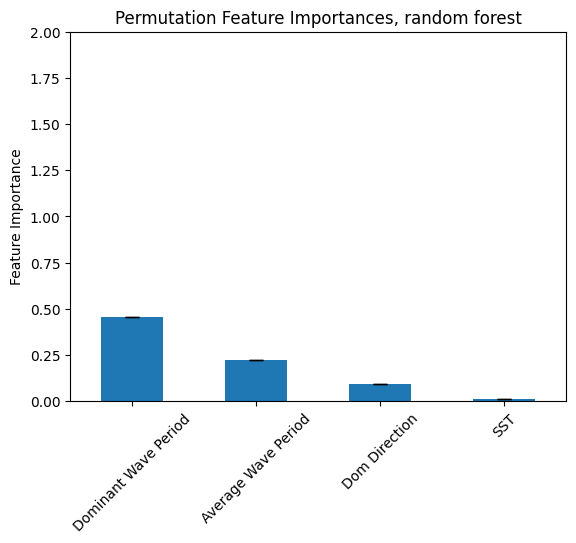

In [97]:
fig, ax = plt.subplots()
buoy_forest_mean_series.plot.bar(yerr=buoy_forest_std, capsize=5, ax=ax)
ax.set_title("Permutation Feature Importances, random forest")
ax.set_ylabel("Feature Importance")

ax.set_ylim(0, 2) 

plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Dominant Wave Period'),
  Text(1, 0, 'Average Wave Period'),
  Text(2, 0, 'Dom Direction'),
  Text(3, 0, 'SST')])

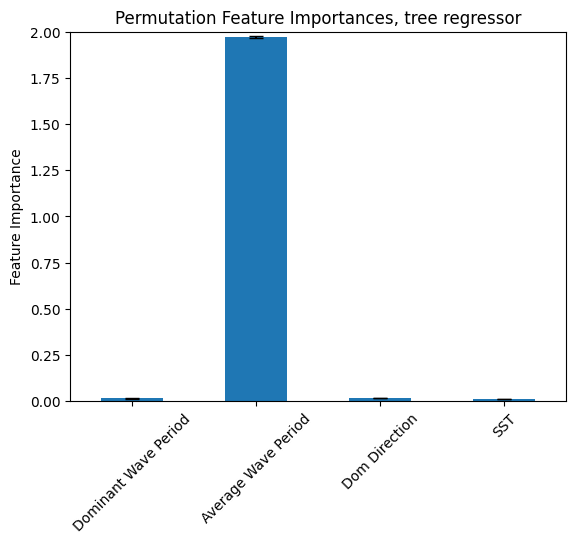

In [98]:
fig, ax = plt.subplots()
buoy_tree_mean_series.plot.bar(yerr=buoy_tree_std, capsize=5, ax=ax)
ax.set_title("Permutation Feature Importances, tree regressor")
ax.set_ylabel("Feature Importance")

ax.set_ylim(0, 2) 

plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Dominant Wave Period'),
  Text(1, 0, 'Average Wave Period'),
  Text(2, 0, 'Dom Direction'),
  Text(3, 0, 'SST')])

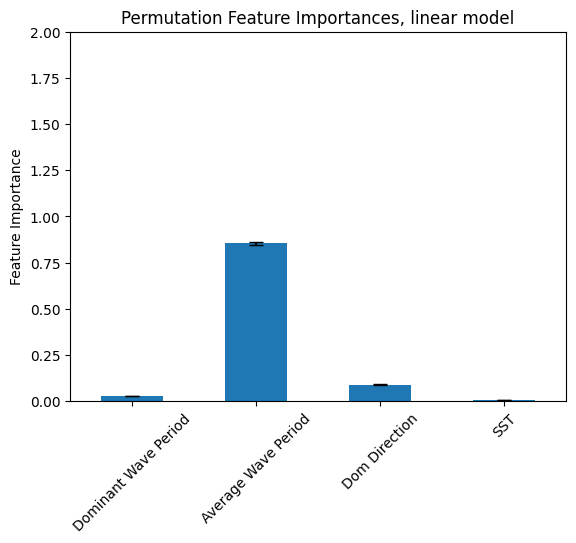

In [99]:
fig, ax = plt.subplots()
buoy_lin_mean_series.plot.bar(yerr=buoy_lin_std, capsize=5, ax=ax)
ax.set_title("Permutation Feature Importances, linear model")
ax.set_ylabel("Feature Importance")

ax.set_ylim(0, 2) 

plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Dominant Wave Period'),
  Text(1, 0, 'Average Wave Period'),
  Text(2, 0, 'Dom Direction'),
  Text(3, 0, 'SST')])

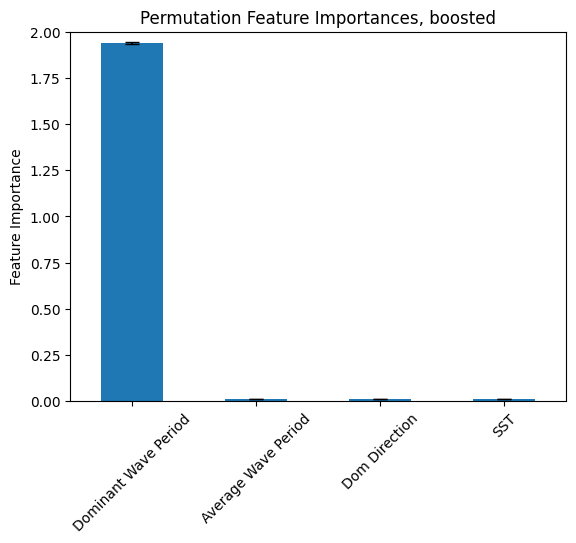

In [100]:
fig, ax = plt.subplots()
buoy_boost_mean_series.plot.bar(yerr=buoy_boost_std, capsize=5, ax=ax)
ax.set_title("Permutation Feature Importances, boosted")
ax.set_ylabel("Feature Importance")

ax.set_ylim(0, 2) 

plt.xticks(rotation=45)